# Lab 5: Spam Detection

**Deadline**: Thursday, July 9, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Baiwu (Chris) Zhang  

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1QwKab8weOwhI57vBJCka4FbSBdV4jcFS?usp=sharing

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
spamcollection = open('/content/drive/My Drive/Colab Notebooks/SMSSpamCollection')

In [ ]:
for line in spamcollection:
  if line[0:3] == 'ham':
    print(line)
    break

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...



In [ ]:
for line in spamcollection:
  if line[0:3] == 'spa':
    print(line)
    break

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



They're called spam or ham

### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [ ]:
hamcount = 0
spamcount = 0
for line in spamcollection:
  if line[0:3] == 'ham':
    hamcount += 1
  if line[0:3] == 'spa':
    spamcount += 1

In [ ]:
print(hamcount)
print(spamcount)

4827
747


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

The first advantage would be that the embedding space would be much smaller. There are countless many words as opposed to just 26 letters in English. Another advantage is that a model based on a sequence of characters has better precision in the scope of each word - it can predict rarely used words (or even punctuations).

However, in the scope of the entire text, character-based would have a much higher computational cost than word-based. Sequence of words would also be much better to capture long-distance dependencies in the text.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [ ]:
import torchtext

text_field = torchtext.data.Field(sequential=True,      # text sequence
                                  tokenize=lambda x: x, # because are building a character-RNN
                                  include_lengths=True, # to track the length of sequences, for batching
                                  batch_first=True,
                                  use_vocab=True)       # to turn each character into an integer index
label_field = torchtext.data.Field(sequential=False,    # not a sequence
                                   use_vocab=False,     # don't need to track vocabulary
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) # convert text to 0 and 1

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.data.TabularDataset("/content/drive/My Drive/Colab Notebooks/SMSSpamCollection", # name of the file
                                        "tsv",               # fields are separated by a tab
                                        fields)


train, valid, test = dataset.split(split_ratio=[0.6, 0.2, 0.2])

OSError: ignored

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [ ]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

If the model can generalise with very high accuracy, imbalance in training set may not have that much effect. But if not, there could be much more misclassifications for classes that have fewer data. This can cause problems when we interpret the result.

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [ ]:
text_field.build_vocab(train)

stoi returns the unique numerical identifiers of all possible characters and itos returns the list of them indexed by the identifiers. 

In [ ]:
text_field.vocab.stoi
#text_field.vocab.itos

defaultdict(<function torchtext.vocab._default_unk_index>,
            {'\t': 102,
             '\n': 103,
             ' ': 2,
             '!': 44,
             '"': 79,
             '#': 80,
             '$': 87,
             '%': 96,
             '&': 64,
             "'": 61,
             '(': 76,
             ')': 71,
             '*': 72,
             '+': 74,
             ',': 46,
             '-': 63,
             '.': 16,
             '/': 59,
             '0': 14,
             '1': 23,
             '2': 26,
             '3': 41,
             '4': 37,
             '5': 32,
             '6': 42,
             '7': 38,
             '8': 28,
             '9': 47,
             ':': 66,
             ';': 75,
             '<': 92,
             '<pad>': 1,
             '<unk>': 0,
             '=': 82,
             '>': 81,
             '?': 60,
             '@': 83,
             'A': 39,
             'B': 55,
             'C': 34,
             'D': 54,
             'E': 31,
        

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

unk refers to the out-of-vocabulary words and pad refers to the padding used for the input sequence.

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [ ]:
train_iter = torchtext.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [ ]:
count = 0
for batch in train_iter:
    print("Batch {0}".format(str(count + 1)))
    maxim = torch.max(batch.sms[1]).item()
    print(maxim) #maximum length of input sequence for each batch
    pad_count = 0
    for i in batch.sms[1]:
        pad_count += maxim - i.item()
    print(pad_count) #padding count
    count += 1
    if count== 9:
        break

Batch 1
32
5
Batch 2
148
33
Batch 3
24
35
Batch 4
39
17
Batch 5
22
8
Batch 6
92
71
Batch 7
145
30
Batch 8
148
0
Batch 9
158
0


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [ ]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [ ]:
class SpamRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SpamRNN, self).__init__()
        self.ident = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.ident[x]
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(torch.max(out, dim=1)[0])
        return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [ ]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataset `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    data_iter = torchtext.data.BucketIterator(data,
                              batch_size=32,
                              sort_key=lambda x: len(x.sms), # to minimize padding
                              sort_within_batch=True, # sort within each batch
                              repeat=False) # repeat the iterator for many epochs
    correct, total = 0, 0
    for batch in data_iter:
        output = model(batch.sms[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(batch.label.view_as(pred)).sum().item()
        total += batch.sms[1].shape[0]
    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

epoch:  0 train acc:  0.8755608734669459 val acc:  0.852914798206278
epoch:  1 train acc:  0.8755608734669459 val acc:  0.852914798206278
epoch:  2 train acc:  0.8755608734669459 val acc:  0.852914798206278
epoch:  3 train acc:  0.9303021238408615 val acc:  0.9246636771300448
epoch:  4 train acc:  0.9718815435237811 val acc:  0.9659192825112107
epoch:  5 train acc:  0.9781633263535746 val acc:  0.9721973094170404
epoch:  6 train acc:  0.9772659288064612 val acc:  0.9730941704035875
epoch:  7 train acc:  0.9778641938378702 val acc:  0.9704035874439462
epoch:  8 train acc:  0.9784624588692791 val acc:  0.9739910313901345
epoch:  9 train acc:  0.979060723900688 val acc:  0.968609865470852
epoch:  10 train acc:  0.9805563864792103 val acc:  0.9704035874439462
epoch:  11 train acc:  0.9811546515106192 val acc:  0.9721973094170404
epoch:  12 train acc:  0.9814537840263237 val acc:  0.9730941704035875
epoch:  13 train acc:  0.9826503140891415 val acc:  0.9739910313901345
epoch:  14 train acc:

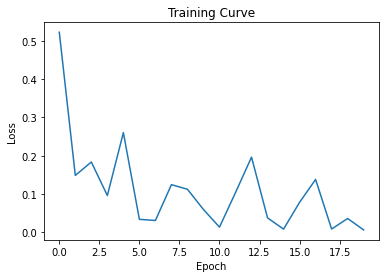

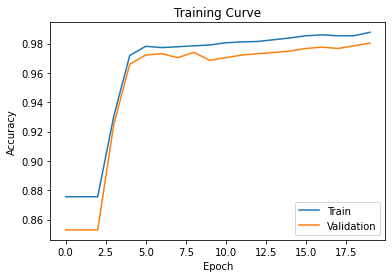

In [ ]:
def get_model_name(name, learning_rate, epoch):
  path = "model_{0}_lr{1}_epoch{2}".format(name, learning_rate, epoch)
  return path

def train_rnn_network(model, train, valid, batch_size=32, num_epochs=30, learning_rate=1e-5):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  losses, train_acc, valid_acc = [], [], []
  epochs = []

  train_loader = torchtext.data.BucketIterator(train,
                          batch_size=batch_size,
                          sort_key=lambda x: len(x.sms), # to minimize padding
                          sort_within_batch=True, # sort within each batch
                          repeat=False) # repeat the iterator for many epochs

  valid_loader = torchtext.data.BucketIterator(valid,
                          batch_size=batch_size,
                          sort_key=lambda x: len(x.sms), # to minimize padding
                          sort_within_batch=True, # sort within each batch
                          repeat=False) # repeat the iterator for many epochs

  for epoch in range(num_epochs):
    for batch in train_loader:
      optimizer.zero_grad()
      pred = model(batch.sms[0])
      loss = criterion(pred, batch.label)
      loss.backward()
      optimizer.step()
    losses.append(float(loss))

    epochs.append(epoch)
    train_acc.append(get_accuracy(model, train))
    valid_acc.append(get_accuracy(model, valid))
    model_path = get_model_name("SpamRNN", learning_rate, epoch)
    torch.save(model.state_dict(), model_path)
    print("epoch: ", epoch, end = " ")
    print("train acc: ", get_accuracy(model, train), end = " ")
    print("val acc: ", get_accuracy(model, valid))

  # plotting
  plt.title("Training Curve")
  plt.plot(losses, label="Train")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Training Curve")
  plt.plot(epochs, train_acc, label="Train")
  plt.plot(epochs, valid_acc, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend(loc='best')
  plt.show()


model = SpamRNN(input_size=len(text_field.vocab), hidden_size=20, num_classes=2)
train_rnn_network(model, train, valid, batch_size=32, num_epochs=20, learning_rate=5e-4)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

First, I changed the number of epochs but that was rather irrelevant in this lab because the accuracy reached the plateau before epoch 20. So I kept the number of epochs at 20. Increasing the learning rate to 5e-4 increased the accuracies by ~5%. Changing the model architecture from max pooling to concatenation between max pooling and average pooling didn't have a significant impact on the result, so I ended up just max pooling. Increasing hidden_size from 20 to 30 also didn't influence the result that much either. The best validation accuracy I obtained was 98.0%.

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [ ]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 1],
    valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid.examples if e.label == 0],
    valid.fields)

In [ ]:
model = SpamRNN(input_size=len(text_field.vocab), hidden_size=20, num_classes=2)
state = torch.load("model_SpamRNN_lr0.0005_epoch19")
model.load_state_dict(state)
print("False negative: ",(1-get_accuracy(model, valid_spam)))
print("False positive: ",(1-get_accuracy(model, valid_nospam)))

False negative:  0.04878048780487809
False positive:  0.02208201892744477


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

False negative would lead the user to think that a spam email is a normal one, and false positive would make him/her to think that a normal email is a spam.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [ ]:
model = SpamRNN(input_size=len(text_field.vocab), hidden_size=20, num_classes=2)
state = torch.load("model_SpamRNN_lr0.0005_epoch19")
model.load_state_dict(state)
get_accuracy(model, test)

0.9649910233393177

### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [ ]:
test_spam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 1],
    test.fields)

test_nospam = torchtext.data.Dataset(
    [e for e in test.examples if e.label == 0],
    test.fields)

In [ ]:
model = SpamRNN(input_size=len(text_field.vocab), hidden_size=20, num_classes=2)
state = torch.load("model_SpamRNN_lr0.0005_epoch19")
model.load_state_dict(state)
print("False negative: ",(1-get_accuracy(model, test_spam)))
print("False positive: ",(1-get_accuracy(model, test_nospam)))

False negative:  0.049645390070921946
False positive:  0.03288797533401855


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [ ]:
msg = "machine learning is sooo cool!"
msg_array = []
for i in msg:
    msg_array.append(text_field.vocab.stoi[i])
msg_tensor = torch.LongTensor([msg_array])

In [ ]:
model = SpamRNN(input_size=len(text_field.vocab), hidden_size=20, num_classes=2)
state = torch.load("model_SpamRNN_lr0.0005_epoch19")
model.load_state_dict(state)

<All keys matched successfully>

In [ ]:
res = model(msg_tensor)

In [ ]:
print(res.max(1, keepdim=True)[1])

tensor([[0]])


This is likely a non spam message

### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

Detecting spam seems to be a difficult task. There are many cases where a spam sounds like a normal message, and vice versa. That's why we build a baseline model for comparison - for our purpose, a baseline model based on word count seems reasonable. It could be a very simple algorithm that counts how many times a certain word is used (that is often used in spam emails but not ham ones). This way, the baseline model would determine what resembles a spam just by certain features, and we would be able to tell if our model can classify based on more subtle differences that that.